# Tradeoff Between Bias and Variance

### Bias and Variance

The *Bias* is the tendency for a model to over-estimate or under-estimate the correct value.

*Variance* is the tendency for a model predictions to vary between experiments. Variance measures how much the model predictions change if we retrain the model on a different sample of data.

We can think of bias and variance as being similar to accuracy and precision respectively. Bias measures how accurate our average prediction is to the true estimate. Variance measures how close muliple iterations of the same model are on slightly different datasets. The main difference between bias and variance, and accuracy and precision is that the first is refering to the average model with a fixed complexity being trained over multiple datasets, and the latter is refering to the average prediction for a fixed dataset. They are similar concepts, but one is dealing with comparing multiple models, and the other is comparing predictions of a single model.

There is a predictable relationship between bias, variance and model complexity. Theoretically bias decreases, and variance increases with model complexity. The objective of this notebook is to demonstrate this.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold

First, we split the process the raw data and build a dataset, which will be split into train and test sets, and a validation dataset. The validation dataset is necessary to for our calculations of bias and variance.

In [2]:
raw = pd.read_csv("heart.csv").sample(frac=1).reset_index(drop=True)
feature_columns = [col for col in raw.columns if col <> "target"]
X_raw = raw[feature_columns].to_numpy()
y_raw = raw["target"].to_numpy()

train_test_samples = int(len(y_raw)*0.8)

X = X_raw[:train_test_samples]
X_val = X_raw[train_test_samples:]
y = y_raw[:train_test_samples]
y_val = y_raw[train_test_samples:]

Now we need to vary the model complexity and record statistics gathered over the validation set. For each max_depth we train a model on a different training set, evaluate on the validation set, and record root-mean-square error as well as the predictions. I am using RMSE as a measure of bias and I need the predictions to calculate variance as you will soon see.

I decided to use RandomForestClassifier (RFC) and vary the max_depth as a control on the model complexity. I was not sure that RFC was a not a good candidate for this demostration since the ensembling might make very variance low and difficult to show. I was not disapointed.

In [3]:
kf = KFold(n_splits = 50)
max_depth_values = range(1,10)

estimator_stats = dict()
rmse_history = []
for max_depth in max_depth_values:
    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create classifier
        rfc = RandomForestClassifier(n_estimators=50, max_depth=max_depth)
        rfc.fit(X_train, y_train)
        prob_pos = rfc.predict_proba(X_val)[:, 1]
        rmse = math.sqrt(sum(((prob_pos - y_val)**2))/len(y_val))
        rmse_history.append((rfc, rmse, prob_pos))
    
    estimator_stats[max_depth] = rmse_history
    rmse_history = []

For each max_depth I calculate the average RMSE as a measure bias, and I calculate the average variance over the predictions on the validtion set as a measure of the variance.

In [6]:
rmses = []
variances = []
for max_depth in max_depth_values:
    rsmes_for_estimator = [x[1] for x in  estimator_stats[max_depth]]
    rmses.append(np.mean(rsmes_for_estimator))
    
    # K prob_pos vectors for each estimator
    prob_pos_vectors_for_estimator = [x[2] for x in  estimator_stats[max_depth]]
    
    variances_for_estimator = []
    for i in range(len(prob_pos_vectors_for_estimator[0])):
        variance = np.var([prob_pos[i] for prob_pos in prob_pos_vectors_for_estimator])
        variances_for_estimator.append(variance)
    variances.append(np.mean(variances_for_estimator))


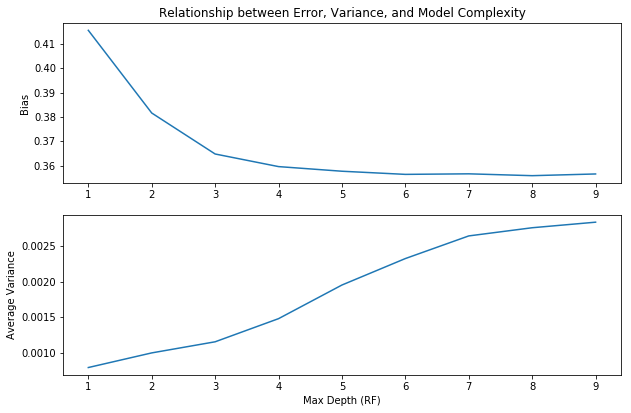

In [21]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0))
ax2 = plt.subplot2grid((3, 1), (1, 0))
ax1.plot(max_depth_values, rmses)
ax2.plot(max_depth_values, variances)

ax1.set_title("Relationship between Error, Variance, and Model Complexity")
ax1.set_ylabel("Bias")

ax2.set_ylabel("Average Variance")
ax2.set_xlabel("Max Depth (RF)")
ax2.set_ylabel("Average Variance")
plt.show()

# Great success! As expected, we see that bias decreases and variances increases with model complexity.